# Toy Example

In this toy example, we will go through the motivation for using Information theory measures as opposed to simple correlation measures.

In [ ]:
import sys, os
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

import pathlib
FIG_PATH = pathlib.Path(str(here())).joinpath('reports/figures/spa_temp/demos')

# standard python packages
import xarray as xr
import pandas as pd
import numpy as np

# 
# Experiment Functions
from src.data.esdc import get_dataset
from src.features import Metrics
from src.features.temporal import select_period, get_smoke_test_time
from src.features.spatial import select_region, get_europe
from src.models.train_models import get_similarity_scores
from src.experiments.utils import dict_product, run_parallel_step

from src.features import Metrics
from src.features.density import get_density_cubes
from src.features.preprocessing import standardizer_data, get_reference_cube, get_common_indices
from src.models.similarity import cka_coefficient, rv_coefficient, rbig_it_measures

# # esdc tools
# from src.esdc.subset import select_pixel
# from src.esdc.shape import ShapeFileExtract, rasterize
# from esdc.transform import DensityCubes

from typing import List, Dict
import xarray as xr
from scipy import stats
from tqdm import tqdm

import cartopy
import cartopy.crs as ccrs

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

## Data

For the toy example, we will show a dataset with two features $\mathbf{x}$ and a corresponding output $y$. One feature will be linearly correlated and the other will have a non-linear correlation.

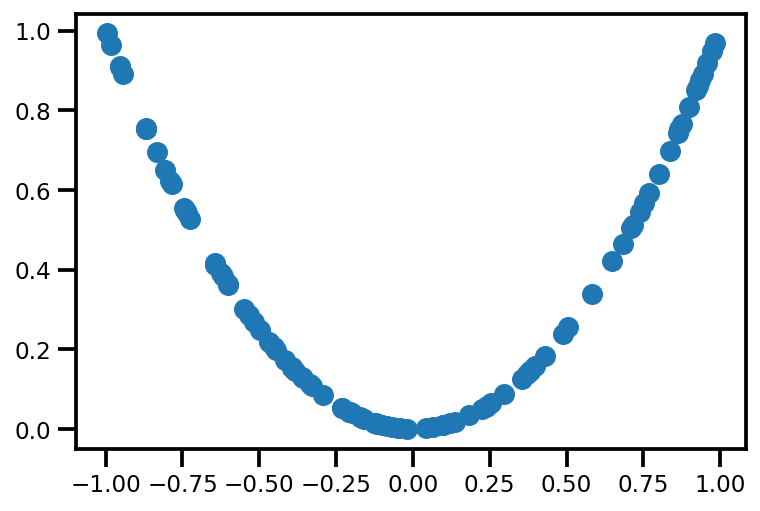

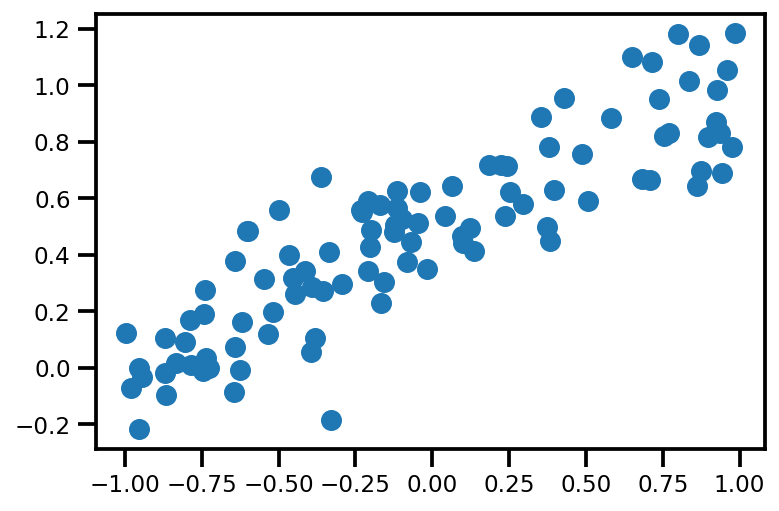

In [2]:
# domain = np
def f1(x): return x**2
def f2(x): return .5 + 0.5 * (x + 0.3 * np.random.randn(x.shape[0]))

x_dist = stats.uniform(loc=-1.0, scale=2.0)
x_samples = x_dist.rvs(100)

y1 = f1(x_samples)

y2 = f2(x_samples)

fig, ax = plt.subplots()
ax.scatter(x_samples, y1)
plt.show()


fig, ax = plt.subplots()
ax.scatter(x_samples, y2)
plt.show()

As you can see, we have two different features which lead to predicting the result (technically). So now, let's try and use some similarity measures to show the difference between the scores we will receive.

In [41]:
# lets generate some extra samples
x_samples  = x_dist.rvs(1000)

y1 = f1(x_samples)
y2 = f2(x_samples)

results_y1 = get_similarity_scores(y1[:, None], x_samples[:, None])
results_y1

0.05437023951950552 0.26585719529588314
293.42834582694337 351.9679737409108
0.45172448519500313


{'coefficient': 0.0019375453082084576,
 'x_norm': 86.56378689864754,
 'y_norm': 321.3035683753114,
 'xy_norm': 53.88943906251051,
 'cka_coeff': 0.45172448519500313,
 'cka_y_norm': 351.9679737409108,
 'cka_x_norm': 293.42834582694337,
 'rbig_H_x': -0.4080861116016834,
 'rbig_H_y': 0.9949518900606531,
 'rbig_H_time': 0.24187374114990234,
 'rbig_I_xy': 4.895751700426538,
 'rbig_I_time': 0.7415869235992432,
 'rbig_I_xx': 54.30540407118974,
 'rbig_Ixx_time': 0.6045341491699219}

In [44]:
results_y2 = get_similarity_scores(y2[:, None], x_samples[:, None])
results_y2

0.07693469294873342 0.26585719529588314
292.92377586393087 351.9679737409108
0.34529078191601875


{'coefficient': 0.7509896642044086,
 'x_norm': 98.70173224302768,
 'y_norm': 321.3035683753114,
 'xy_norm': 23816.2995183097,
 'cka_coeff': 0.34529078191601875,
 'cka_y_norm': 351.9679737409108,
 'cka_x_norm': 292.92377586393087,
 'rbig_H_x': 0.34133325847657137,
 'rbig_H_y': 0.9949518900606531,
 'rbig_H_time': 0.24291515350341797,
 'rbig_I_xy': 0.9779206932596405,
 'rbig_I_time': 0.516376256942749,
 'rbig_I_xx': 55.00484108618267,
 'rbig_Ixx_time': 0.5206396579742432}

In [45]:
results_y1 = get_similarity_scores(np.vstack([x_samples, x_samples]).T, 
    np.vstack([y1, y2]).T, )
results_y1

0.5317143905917663 0.19633644009368156
354.07998648329635 257.73652904556116
0.6376530719734113


{'coefficient': 0.5650989816810225,
 'x_norm': 642.6071367506228,
 'y_norm': 131.4667065790006,
 'xy_norm': 47740.37791474441,
 'cka_coeff': 0.6376530719734113,
 'cka_y_norm': 257.73652904556116,
 'cka_x_norm': 354.07998648329635,
 'rbig_H_x': -51.82782267461724,
 'rbig_H_y': -0.4157391263358212,
 'rbig_H_time': 0.6667172908782959,
 'rbig_I_xy': 6.380694361934436,
 'rbig_I_time': 1.9837839603424072,
 'rbig_I_xx': 112.17904005545456,
 'rbig_Ixx_time': 1.233093023300171}

#### Method I - Pearson / RV

Now, we will explore the easiest linear method. It is the multi-dimensional version of the Pearson Correlation coefficient called the $\rho$V-Coefficient ($\rho$-Vector Coefficient). Most people are familiar with the correlation coefficient:

$$
\rho(X,Y) = \frac{\text{Cov}(X,Y)}{\sqrt{\text{Var}(X)}\sqrt{\text{Var}(Y)}}
$$


This is very well-known in the literature but it doesn't directly apply to multi-dimensional data. The final result of the numerator and the denominator is a scalar value per dimension. There is no way we can summarize all of the information into a single scalar. One extension we can do is to create a matrix with the pairwise components (i.e gram matrices) for each of the variables and then take the Frobenius norm (Hilbert-Schmidt norm) of the cross term as well as the individual terms. So the equation is like so:

$$
\rho V (\mathbf{X,Y}) = 
\frac{\left\langle \mathbf{XX^\top, YY^\top} \right\rangle_\mathbf{F}}
{\sqrt{\left\langle \mathbf{XX^\top} \right\rangle_\mathbf{F}}
\sqrt{\left\langle \mathbf{YY^\top} \right\rangle_\mathbf{F}}}
$$

**Note**: This is very similar to HSIC and Centered Kernel Alignment (CKA) but this method dates back before. CKA generalizes this method with the addition of distance measures and non-linear kernel functions. We will explore this in the next section.

To code this up, we will all of the components of this equation because we will need them later.

In [24]:
from typing import Dict
from sklearn.preprocessing import KernelCenterer
from sklearn.metrics.pairwise import linear_kernel


def rv_coefficient_(X: np.ndarray, Y: np.ndarray) -> Dict:
    """simple function to calculate the rv coefficient"""
    print(X.shape, Y.shape)
    # calculate the kernel matrices
    X_gram = linear_kernel(X)
    Y_gram = linear_kernel(Y)

    # center the kernels
    X_gramc = KernelCenterer().fit_transform(X_gram)
    Y_gramc = KernelCenterer().fit_transform(Y_gram)

    # normalizing coefficients (denomenator)
    x_norm = np.linalg.norm(X_gramc)
    y_norm = np.linalg.norm(Y_gramc)

    # frobenius norm of the cross terms (numerator)
    xy_norm = np.einsum("ij,ij->", X_gramc, Y_gramc)
    # rv coefficient
    pv_coeff = xy_norm / x_norm / y_norm

    return {
        "coefficient": pv_coeff,
        "x_norm": x_norm,
        "y_norm": y_norm,
        "xy_norm": xy_norm,
    }

feat_ = rv_coefficient_(x_samples[:, None], y2[:, None])
# print(feat1_coeff)

(1000, 1) (1000, 1)


In [28]:
from src.models.similarity import rv_coefficient
feat1_coeff = rv_coefficient(x_samples[:, None], y2[:, None])
feat1_coeff
# correlation for feature 1


(1000, 1) (1000, 1)


In [26]:
np.testing.assert_array_equal(feat_['X_gram'], feat1_coeff['X_gram'])

In [30]:
feat1_coeff = rv_coefficient(x_samples[:, None], y1[:, None])
print(feat1_coeff['coefficient'])

# correlation for feature 2
feat2_coeff = rv_coefficient_(x_samples[:, None], y2[:, None])
print(feat2_coeff['coefficient'])

# combined correlation
feat3_coeff = rv_coefficient_(
    np.vstack([x_samples, x_samples]).T, 
    np.vstack([y1, y2]).T, 
)
print(feat3_coeff['coefficient'])

(1000, 1) (1000, 1)
0.00242934372482955
(1000, 1) (1000, 1)
0.7591093655341886
(1000, 2) (1000, 2)
0.5957128880697461


#### Method II - PDF Estimation



In [62]:
# lets generate some extra samples
x_samples  = x_dist.rvs(1000)

y1 = f1(x_samples)
y2 = f2(x_samples)
it_results = {}

In [63]:
it_results['h_x'] = stats.rv_histogram(np.histogram(x_samples)).entropy()
it_results['h_y1'] = stats.rv_histogram(np.histogram(y1)).entropy()
it_results['h_y2'] = stats.rv_histogram(np.histogram(y2)).entropy()

it_results

{'h_x': array(0.688), 'h_y1': array(-0.232), 'h_y2': array(0.269)}

In [64]:
mutual_info_score(y1, x_samples), mutual_info_score(y2, x_samples)

(6.907755278982134, 6.907755278982134)

In [32]:
from src.models.similarity import rbig_it_measures
from sklearn.metrics import mutual_info_score

In [33]:
res = rbig_it_measures(x_samples[:, None], y1[:, None])
res

{'rbig_H_x': 0.981723077734924,
 'rbig_H_y': -0.3287622066023843,
 'rbig_H_time': 0.24280524253845215,
 'rbig_I_xy': 4.393081415895844,
 'rbig_I_time': 0.7454361915588379,
 'rbig_I_xx': 54.589945026176615,
 'rbig_Ixx_time': 0.5341296195983887}

In [35]:
res = rbig_it_measures(x_samples[:, None], y2[:, None])
res

{'rbig_H_x': 0.981723077734924,
 'rbig_H_y': 0.3724089062570579,
 'rbig_H_time': 0.247999906539917,
 'rbig_I_xy': 0.9115252322138834,
 'rbig_I_time': 0.6650967597961426,
 'rbig_I_xx': 54.589945026176615,
 'rbig_Ixx_time': 0.5337388515472412}

In [36]:
res = rbig_it_measures(    np.vstack([x_samples, x_samples]).T, 
    np.vstack([y1, y2]).T, )
res

{'rbig_H_x': -53.12847385371654,
 'rbig_H_y': -0.28167550633541083,
 'rbig_H_time': 0.5551707744598389,
 'rbig_I_xy': 10.37108493597718,
 'rbig_I_time': 1.251359462738037,
 'rbig_I_xx': 119.71896601317108,
 'rbig_Ixx_time': 1.5202088356018066}

In [34]:
%%time
from rbig.rbig import RBIGMI, RBIG

rbig_results = {}

n_layers = 10000
rotation_type = 'PCA'
random_state = 0
zero_tolerance = 60
pdf_extension = None
pdf_resolution = None
tolerance = None

# Initialize RBIG class
H_rbig_model = RBIG(n_layers=n_layers, 
                  rotation_type=rotation_type, 
                  random_state=random_state, 
                  zero_tolerance=zero_tolerance,
                  tolerance=tolerance)

# fit model to the data
rbig_results['H_x'] = H_rbig_model.fit(x_samples[:, None]).entropy(correction=True);

# fit model to the data
rbig_results['H_y1'] = H_rbig_model.fit(y1[:, None]).entropy(correction=True);

rbig_results['H_y2'] = H_rbig_model.fit(y2[:, None]).entropy(correction=True);



# # calculate the variation of information coefficient
# rbig_results['coefficient'] = variation_of_info(
#     rbig_results['H_x'],
#     rbig_results['H_y'],
#     rbig_results['I_xy']
# )
rbig_results

CPU times: user 178 ms, sys: 50 µs, total: 178 ms
Wall time: 176 ms


{'H_x': 0.981723077734924,
 'H_y1': -0.3287622066023843,
 'H_y2': 0.3724089062570579}

In [37]:
# Initialize RBIG class
n_layers = 10000
rotation_type = "PCA"
random_state = 0
zero_tolerance = 60
pdf_extension = 10

I_rbig_model = RBIGMI( 
        n_layers=n_layers,
        rotation_type=rotation_type,
        random_state=random_state,
        pdf_extension=pdf_extension,
        zero_tolerance=zero_tolerance,
                     )

# fit model to the data
rbig_results['I_xy1'] = I_rbig_model.fit(x_samples[:, None], y1[:, None]).mutual_information();
rbig_results['I_xy2'] = I_rbig_model.fit(x_samples[:, None], y2[:, None]).mutual_information();

In [38]:
rbig_results

{'H_x': 0.981723077734924,
 'H_y1': -0.3287622066023843,
 'H_y2': 0.3724089062570579,
 'I_xy1': 4.393081415895844,
 'I_xy2': 0.9115252322138834}

In [ ]:
# correlation for feature 1
feat1_coeff = rv_coefficient(x[:, None], y1[:, None])
print(feat1_coeff['coefficient'])

# correlation for feature 2
feat2_coeff = rv_coefficient(x[:, None], y2[:, None])
print(feat2_coeff['coefficient'])

In [78]:
from src.models.similarity import cka_coefficient, estimate_sigma
from sklearn.gaussian_process.kernels import RBF

In [100]:
sigma_X = estimate_sigma(x_samples[:, None], percent=50)
sigma_Y = estimate_sigma(y1[:, None], percent=50)
print(sigma_X, sigma_Y)
# calculate the kernel matrices
X_gram = RBF(sigma_X)(x_samples[:, None])
Y_gram = RBF(sigma_Y)(y1[:, None])

# center the kernels
X_gram = KernelCenterer().fit_transform(X_gram)
Y_gram = KernelCenterer().fit_transform(Y_gram)

# normalizing coefficients (denomenator)
x_norm = np.linalg.norm(X_gram)
y_norm = np.linalg.norm(Y_gram)
print(x_norm, y_norm)
# frobenius norm of the cross terms (numerator)
xy_norm = np.sum(X_gram * Y_gram)
print(xy_norm)
# rv coefficient
pv_coeff = xy_norm / x_norm / y_norm
print(pv_coeff)

0.2657691899796979 0.05311986912963971
352.84673138128977 291.7013677338769
45628.201297890504
0.44331128277714194


In [39]:
res_cka1 = cka_coefficient(x_samples[:, None], y1[:, None])
res_cka1

0.2844356155003263 0.06708848486234353
359.5207930692671 309.34605864869707
0.4218904276535793


{'cka_coeff': 0.4218904276535793,
 'cka_y_norm': 309.34605864869707,
 'cka_x_norm': 359.5207930692671}

In [40]:
res_cka1 = cka_coefficient(x_samples[:, None], y2[:, None])
res_cka1

0.2844356155003263 0.08403546313975278
359.5207930692671 298.00834882920657
0.38619484472728116


{'cka_coeff': 0.38619484472728116,
 'cka_y_norm': 298.00834882920657,
 'cka_x_norm': 359.5207930692671}

In [158]:
npz = np.load('partitions_cd.npz', allow_pickle=True) 
df = pd.DataFrame.from_dict({item:[npz[item]] for item in npz.files}, orient='columns') 
# df = pd.DataFrame({'norm_rates': df['norm_rates'][0]}, index=[0])
df.head()

,norm_rates,norm_variables,y_clust,y_clust_centers,range_n_clusters
0,"[[-0.5701604961541259, 0.5192818283898029, 0.6...","[[-0.3090169943749474, 0.0, 0.9510565162951535...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[-0.32052206362580005, -0.001829013479382394...","[2, 3, 4]"


In [194]:
df['y_clust_centers'].values[0][0].shape

(2, 3)

In [191]:
subdf = pd.DataFrame(df['range_n_clusters'].values[0])
subdf.to_csv('range_n_clusters.csv', index=False)

In [174]:
subdf.shape

(400, 3)

In [124]:
npz = np.load('partitions_cd.npz', allow_pickle=True)
df = [(item, pd.DataFrame.from_dict({item:[npz[item]]}, orient='columns')) for item in npz.files]
for item, frame in df:
    frame.to_csv(f"{item}.csv")

In [117]:
df.to_csv('partitions_cd.csv')

In [129]:
pd.read_csv('norm_variables.csv')['norm_variables'][0]

'[[-0.309  0.     0.951]\n [ 0.866  0.5    0.   ]]'

In [118]:
df2 = pd.read_csv('partitions_cd.csv')
df2.head()

,Unnamed: 0,norm_rates,norm_variables,y_clust,y_clust_centers,range_n_clusters
0,0,[[-0.57 0.519 0.637]\n [-0.497 0.076 0.86...,[[-0.309 0. 0.951]\n [ 0.866 0.5 0. ]],"[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[array([[-0.321, -0.002, 0.947],\n [ 0....",[2 3 4]


In [119]:
pd.testing.assert_frame_equal(df, df2)

AssertionError: DataFrame are different

DataFrame shape mismatch
[left]:  (1, 5)
[right]: (1, 6)